### What are the most popular books on  external factors (sociological, political, economic, historical, environmental, cultural, technological) at the same time as popular self help books?

In [1]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("BrightData/Goodreads-Books", split='train', streaming=True)
sample = ds.take(100000)  

import pandas as pd

# Convert sample into df and filter for books with 50+ ratings
df = pd.DataFrame(sample)
df = df[df['num_ratings'] >= 50]

df.head()
print(len(df))

# Extract year from first_published and create new column with error handling
df['year_published'] = pd.to_datetime(df['first_published'], format='%m/%d/%Y', errors='coerce').dt.year

# Reorder columns to put year_published next to first_published 
cols = list(df.columns)
first_published_idx = cols.index('first_published')
cols.remove('year_published')
cols.insert(first_published_idx + 1, 'year_published')
df = df[cols]

df.head()


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


13808


In [18]:
# # Create masks for Self Help and Nonfiction books, handling None values
# self_help_mask = df['genres'].apply(lambda x: 'Self Help' in x if x is not None else False)
# nonfiction_mask = df['genres'].apply(lambda x: 'Nonfiction' in x if x is not None else False)

# # Get yearly counts for both genres
# self_help_by_year = df[self_help_mask].groupby('year_published').size()
# nonfiction_by_year = df[nonfiction_mask].groupby('year_published').size()

# # Combine into a DataFrame for comparison
# comparison_df = pd.DataFrame({
#     'Self Help': self_help_by_year,
#     'Nonfiction': nonfiction_by_year
# }).fillna(0)

# # Only keep years that have at least one self-help book
# comparison_df = comparison_df[comparison_df['Self Help'] > 0]

# # Sort by year
# comparison_df = comparison_df.sort_index()

# # Display results
# print("Yearly comparison of Self Help vs Nonfiction books:")
# print(comparison_df)

# # Optional: Create a visualization
# import matplotlib.pyplot as plt

# comparison_df.plot(kind='bar', figsize=(15, 6))
# plt.title('Self Help vs Nonfiction Books by Year')
# plt.xlabel('Year')
# plt.ylabel('Number of Books')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Create a mask for Nonfiction books, handling None values
# nonfiction_mask = df['genres'].apply(lambda x: 'Nonfiction' in x if x is not None else False)

# # Get all records that contain Nonfiction
# nonfiction_records = df[nonfiction_mask]

# # Function to extract other genres from records containing Nonfiction
# def get_other_genres(genre_list):
#     if genre_list is None:
#         return []
#     # Convert string representation of list to actual list
#     import ast
#     genres = ast.literal_eval(genre_list)
#     # Return all genres except Nonfiction
#     return [genre for genre in genres if genre != 'Nonfiction']

# # Get all other genres that appear alongside Nonfiction
# other_genres = nonfiction_records['genres'].apply(get_other_genres)

# # Flatten the list of lists and count occurrences of each genre
# from collections import Counter
# genre_counts = Counter([genre for sublist in other_genres for genre in sublist])

# print("Genres that appear alongside 'Nonfiction' (with counts):")
# for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
#     print(f"- {genre}: {count} books")


# Create list of external genres we want to check for
external_genres = ['Politics', 'Science', 'Psychology', 'Philosophy', 'Business', 'History', 'Sociology', 'Education']

# Create masks for self help and external genres
self_help_mask = df['genres'].apply(lambda x: 'Self Help' in x if x is not None else False)
external_mask = df['genres'].apply(lambda x: 'Nonfiction' in x and any(genre in x for genre in external_genres) if x is not None else False)

# Combine masks to get all relevant records
combined_mask = self_help_mask | external_mask

# Create new dataframe with only the relevant records
filtered_df = df[combined_mask].copy()

# Create the in_ext column
filtered_df['in_ext'] = 'external'  # Set default value
filtered_df.loc[self_help_mask, 'in_ext'] = 'internal'  # Override for self-help books

print(f"Number of records in filtered dataset: {len(filtered_df)}")
# Count and print number of internal vs external records
internal_count = len(filtered_df[filtered_df['in_ext'] == 'internal'])
external_count = len(filtered_df[filtered_df['in_ext'] == 'external'])

print(f"Number of internal (self-help) records: {internal_count}")
print(f"Number of external records: {external_count}")

# Calculate average number of reviews for each category
internal_avg_reviews = filtered_df[filtered_df['in_ext'] == 'internal']['num_reviews'].mean()
external_avg_reviews = filtered_df[filtered_df['in_ext'] == 'external']['num_reviews'].mean()

print(f"\nAverage number of reviews for internal (self-help) books: {internal_avg_reviews:.2f}")
print(f"Average number of reviews for external books: {external_avg_reviews:.2f}")





Number of records in filtered dataset: 2202
Number of internal (self-help) records: 385
Number of external records: 1817

Average number of reviews for internal (self-help) books: 196.57
Average number of reviews for external books: 79.41


In [22]:
# Import zero-shot classification from transformers
from transformers import pipeline
from tqdm.auto import tqdm
tqdm.pandas()  # This enables .progress_apply

# Initialize zero-shot classifier
classifier = pipeline("zero-shot-classification")

# Define our categories
categories = [
    "A book that investigates and seeks to understand external forces that impact individuals",
    "A book about other topics"
]

# Function to classify text
def classify_summary(text):
    if pd.isna(text):
        return False
    try:
        result = classifier(text, categories)
        # Return True if the first category has highest score
        return result['labels'][0] == categories[0]
    except:
        return False

# Apply classification only to external books' summaries
print("Classifying summaries of external books... (this may take a while)")
filtered_df['external_checked'] = False  # Initialize all as False
external_mask = filtered_df['in_ext'] == 'external'
filtered_df.loc[external_mask, 'external_checked'] = filtered_df.loc[external_mask, 'summary'].progress_apply(classify_summary)

# Print results
print("\nClassification Results:")
print(filtered_df['external_checked'].value_counts())

# Print breakdown for external books only
external_results = filtered_df[filtered_df['in_ext'] == 'external']['external_checked'].value_counts()
print("\nBreakdown for external books:")
print(external_results)
print(f"\nPercentage of external books about external forces: {(external_results.get(True, 0) / external_results.sum()) * 100:.2f}%")


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Classifying summaries of external books... (this may take a while)


100%|██████████| 1817/1817 [14:13<00:00,  2.13it/s]


Classification Results:
external_checked
True     1429
False     773
Name: count, dtype: int64

Breakdown for external books:
external_checked
True     1429
False     388
Name: count, dtype: int64

Percentage of external books about external forces: 78.65%


In [29]:
# Export filtered_df to CSV
filtered_df.to_csv('filtered_self_help_books.csv', index=False)
print("Data exported to 'filtered_self_help_books.csv'")


Data exported to 'filtered_self_help_books.csv'


### Which historical, cultural, or technological events correlate with noticeable shifts in self-help themes?

/var/folders/pc/j_zmpc9s0g9frv2jzfv1l51c0000gn/T/ipykernel_70727/716816382.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1500x800 with 0 Axes>

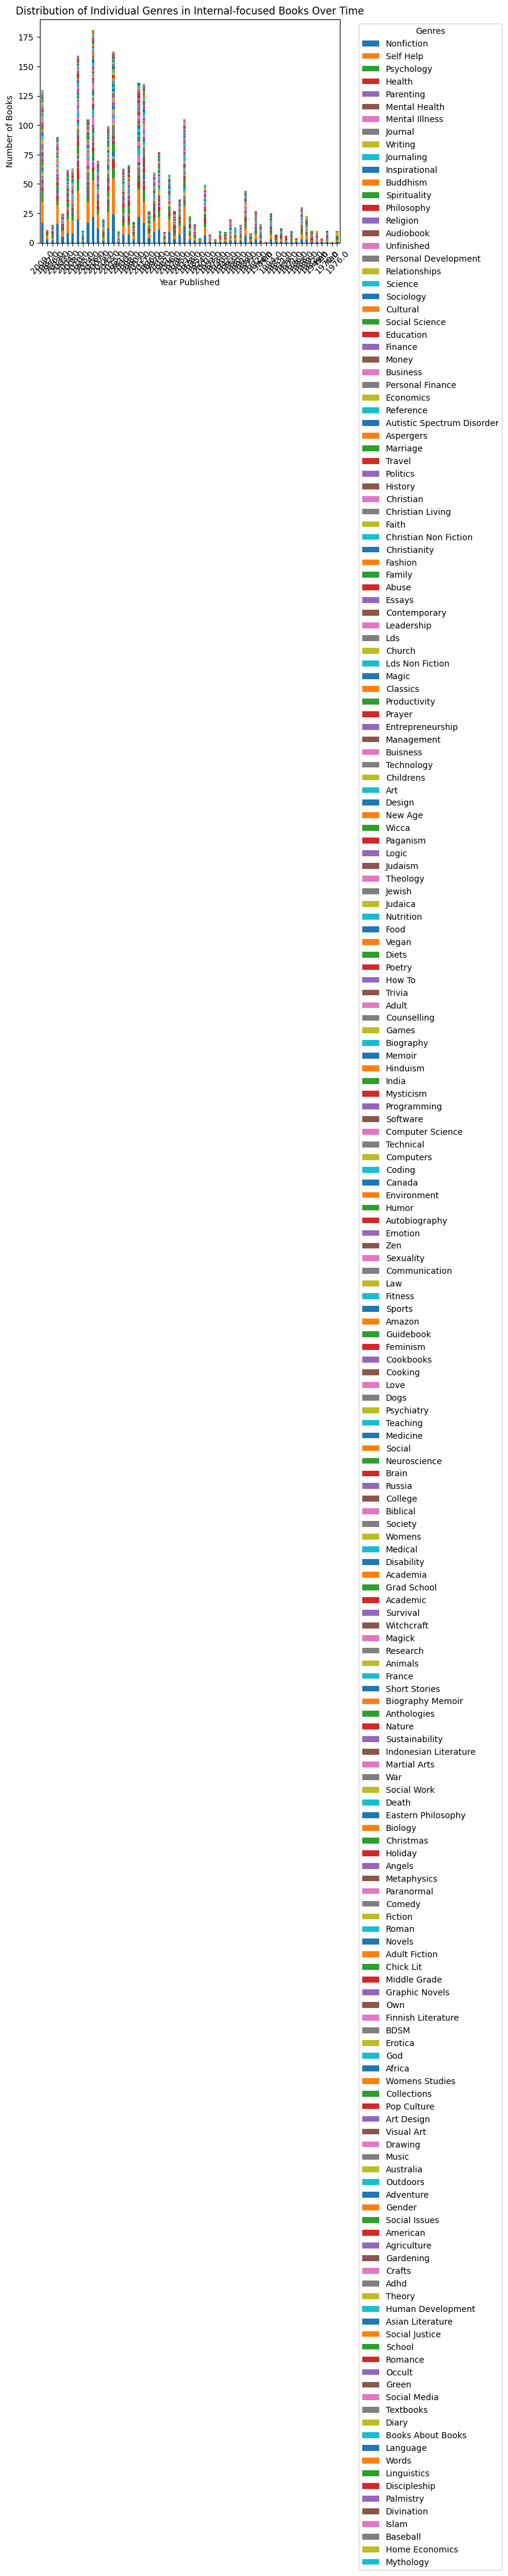


Total counts for each individual genre in internal-focused books:
Self Help: 385
Nonfiction: 337
Psychology: 148
Personal Development: 94
Spirituality: 89
Business: 74
Health: 69
Reference: 63
Philosophy: 58
Audiobook: 51
Leadership: 39
Science: 37
Mental Health: 36
Christian: 36
Relationships: 34
Religion: 33
Inspirational: 30
Parenting: 26
Education: 25
How To: 21
Productivity: 20
Adult: 18
Faith: 17
Communication: 16
Finance: 16
Christian Living: 15
Biography: 15
Management: 15
Nutrition: 14
Food: 14
Sociology: 14
Unfinished: 14
Memoir: 13
Money: 13
Christianity: 13
Entrepreneurship: 12
Economics: 12
Humor: 11
Buddhism: 11
Christian Non Fiction: 11
Writing: 11
Buisness: 11
Personal Finance: 10
Fitness: 10
Counselling: 9
Family: 9
Medical: 9
Cooking: 9
Cookbooks: 9
Childrens: 8
Journaling: 8
Marriage: 8
Art: 8
Diets: 7
Medicine: 7
Essays: 7
Womens: 7
History: 7
Church: 7
Love: 7
New Age: 7
Metaphysics: 7
Mental Illness: 6
Journal: 6
Autobiography: 6
Sexuality: 6
Lds: 6
Design: 6
Ama

In [24]:
import matplotlib.pyplot as plt
import ast

# Filter for internal books
internal_books = filtered_df[filtered_df['in_ext'] == 'internal']

# Extract individual genres from the list strings and count them by year
genre_counts = {}
for _, row in internal_books.iterrows():
    year = row['year_published']
    if year not in genre_counts:
        genre_counts[year] = {}
    
    # Convert string representation of list to actual list
    genres = ast.literal_eval(row['genres'])
    for genre in genres:
        if genre not in genre_counts[year]:
            genre_counts[year][genre] = 0
        genre_counts[year][genre] += 1

# Convert to DataFrame for plotting
yearly_genres_df = pd.DataFrame(genre_counts).fillna(0)

# Create stacked bar chart
plt.figure(figsize=(15, 8))
yearly_genres_df.T.plot(kind='bar', stacked=True)

plt.title('Distribution of Individual Genres in Internal-focused Books Over Time')
plt.xlabel('Year Published')
plt.ylabel('Number of Books')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Print total counts for each individual genre
print("\nTotal counts for each individual genre in internal-focused books:")
all_genre_counts = {}
for _, row in internal_books.iterrows():
    genres = ast.literal_eval(row['genres'])
    for genre in genres:
        if genre not in all_genre_counts:
            all_genre_counts[genre] = 0
        all_genre_counts[genre] += 1

# Sort and print genre counts
for genre, count in sorted(all_genre_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre}: {count}")


### How can natural language processing or topic modeling be used to cluster self-help titles into thematic groups?

### What insights can be gained about which self-help books might be most effective based on individual profiles?

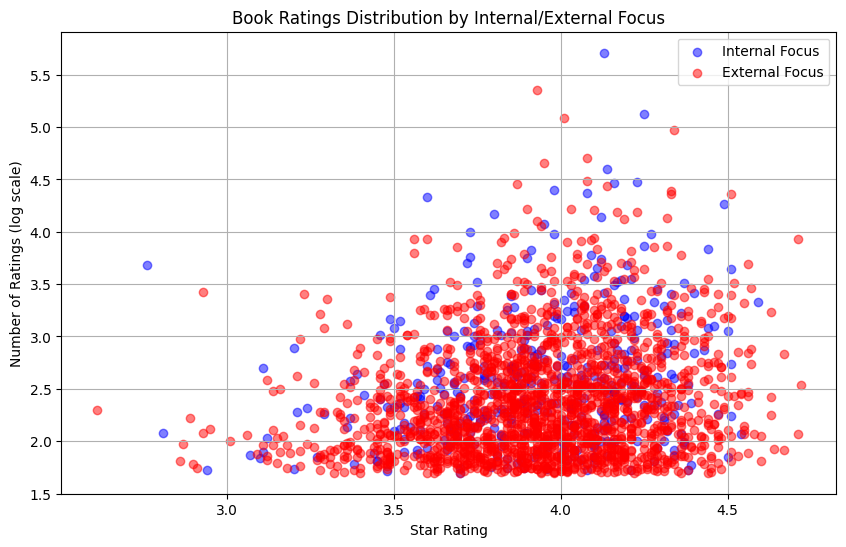

In [26]:
# Create scatter plot of ratings with color coding for internal/external
plt.figure(figsize=(10, 6))

# Plot internal books
internal_mask = filtered_df['in_ext'] == 'internal'
plt.scatter(filtered_df[internal_mask]['star_rating'], 
           filtered_df[internal_mask]['num_ratings'].apply(np.log10),
           alpha=0.5, 
           label='Internal Focus',
           color='blue')

# Plot external books 
external_mask = filtered_df['in_ext'] == 'external'
plt.scatter(filtered_df[external_mask]['star_rating'],
           filtered_df[external_mask]['num_ratings'].apply(np.log10), 
           alpha=0.5,
           label='External Focus',
           color='red')

plt.xlabel('Star Rating')
plt.ylabel('Number of Ratings (log scale)')
plt.title('Book Ratings Distribution by Internal/External Focus')
plt.legend()
plt.grid(True)
plt.show()

### How might advances in AI and generative content personalize and reshape the future of self-help?

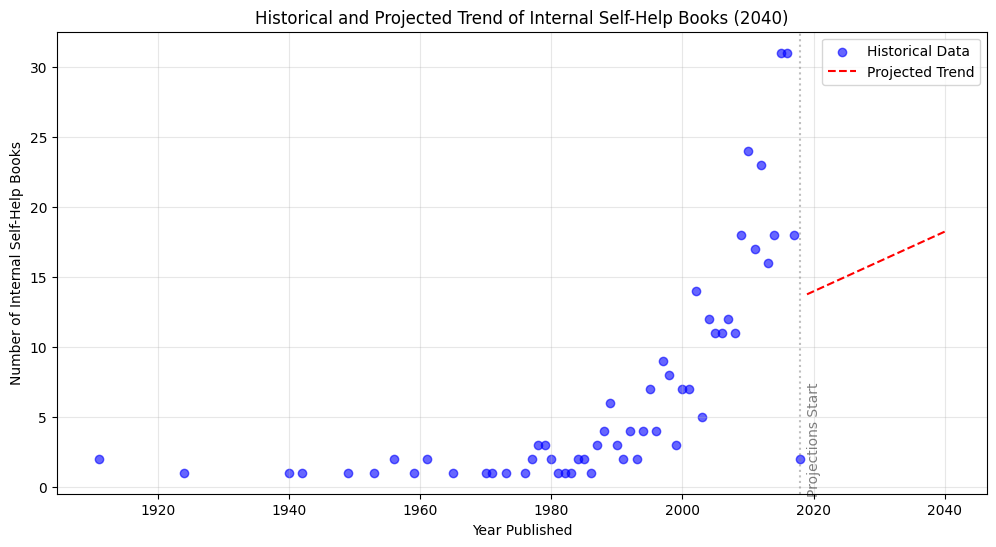

In [28]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Plot historical trend of internal self-help books
internal_by_year = filtered_df[filtered_df['in_ext'] == 'internal'].groupby('year_published').size().reset_index(name='count')

# Create future years for projection
future_years = pd.DataFrame({'year_published': range(int(internal_by_year['year_published'].max()) + 1, 2041)})

# Fit linear regression
X = internal_by_year['year_published'].values.reshape(-1, 1)
y = internal_by_year['count'].values
model = LinearRegression()
model.fit(X, y)

# Make predictions for future years
future_predictions = model.predict(future_years['year_published'].values.reshape(-1, 1))

# Combine historical and projected data
projection_df = pd.concat([
    internal_by_year,
    pd.DataFrame({'year_published': future_years['year_published'], 'count': future_predictions})
])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot historical data
plt.scatter(internal_by_year['year_published'], internal_by_year['count'], 
           color='blue', label='Historical Data', alpha=0.6)

# Plot projected data
plt.plot(future_years['year_published'], future_predictions, 
         color='red', linestyle='--', label='Projected Trend')

plt.xlabel('Year Published')
plt.ylabel('Number of Internal Self-Help Books')
plt.title('Historical and Projected Trend of Internal Self-Help Books (2040)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add vertical line to separate historical from projected data
plt.axvline(x=internal_by_year['year_published'].max(), color='gray', 
            linestyle=':', alpha=0.5)
plt.text(internal_by_year['year_published'].max() + 1, plt.ylim()[0], 
         'Projections Start', rotation=90, alpha=0.5)

plt.show()
